In [1]:
import tensorflow as tf
import numpy as np

# 自动求导数

## 对变量求导

In [5]:
# 求e**x + bx +c 的导数

e = tf.constant(np.e)
x = tf.Variable(1.0,dtype= tf.float32)
b = tf.constant(2.0)
c = tf.constant(1.0)

with tf.GradientTape() as tape:
    y = tf.pow(e,x) + b*x +c

dy = tape.gradient(y,x)
print(dy)

tf.Tensor(4.7182817, shape=(), dtype=float32)


## 对常量求导

In [6]:
with tf.GradientTape() as tape:
    tape.watch([e,b])
    y = tf.pow(e,x) + b*x +c

dy_x,dy_e,dy_b = tape.gradient(y,[x,e,b])
dy_x,dy_e,dy_b

(<tf.Tensor: shape=(), dtype=float32, numpy=4.7182817>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

## 求高阶导数

In [8]:
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape1:
        y = tf.pow(e,x) + b*x +c
    dy_x = tape1.gradient(y,x)
dy2_x = tape2.gradient(dy_x,x)
print(dy2_x)

tf.Tensor(2.7182813, shape=(), dtype=float32)


# 自动求导与优化器一起使用

In [9]:
x = tf.Variable(0.0)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
@ tf.function
def minimizef():
    a = tf.constant(1.0)
    b = tf.constant(-3.0)
    c = tf.constant(2.0)
    for _ in tf.range(1000): #注意autograph时使用tf.range(1000)而不是range(1000)
        with tf.GradientTape() as tape:
            y = a*tf.pow(x,2) + b*x + c
        dy_dx = tape.gradient(y,x)
        optimizer.apply_gradients(grads_and_vars=[(dy_dx,x)])
    y = a*tf.pow(x,2) + b*x + c
    return y
tf.print(minimizef(),x)

-0.25 1.49999714


In [11]:
x = tf.Variable(0.0,name = "x",dtype = tf.float32)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)   

@tf.function
def f():   
    a = tf.constant(1.0)
    b = tf.constant(-2.0)
    c = tf.constant(1.0)
    y = a*tf.pow(x,2)+b*x+c
    return(y)

@tf.function
def train(epoch):
    for _ in tf.range(epoch):
        optimizer.minimize(f,[x])
    return(f())
tf.print(train(1000),x)

0 0.999998569


# 低价API实现线性回归模型

In [12]:
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8+timestring)


In [13]:
import pandas as pd
from matplotlib import pyplot as plt 


#样本数量
n = 400

# 生成测试用数据集
X = tf.random.uniform([n,2],minval=-10,maxval=10) 
w0 = tf.constant([[2.0],[-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)  # @表示矩阵乘法,增加正态扰动

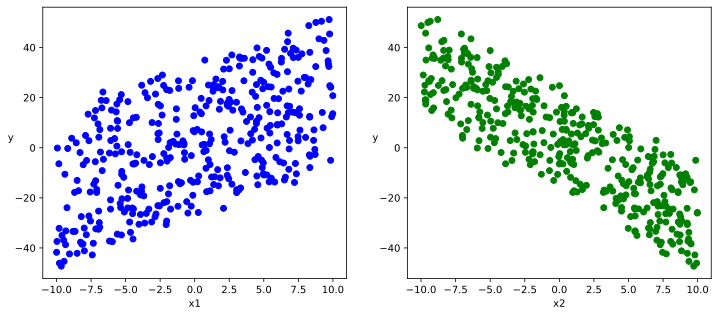

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b")
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g")
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()


In [15]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i + batch_size, num_examples)]
        yield tf.gather(features,indexs), tf.gather(labels,indexs)
        
# 测试数据管道效果   
batch_size = 8
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tf.Tensor(
[[-9.602199   5.6130695]
 [-5.2627325  4.643488 ]
 [-1.156683  -6.995778 ]
 [ 6.508335  -6.921978 ]
 [-4.464214   9.343784 ]
 [-9.186108  -5.1584816]
 [ 7.9260445 -4.5368314]
 [-3.9091659  4.817831 ]], shape=(8, 2), dtype=float32)
tf.Tensor(
[[-35.01319   ]
 [-20.370613  ]
 [ 23.69794   ]
 [ 39.28555   ]
 [-36.424587  ]
 [ -0.30012128]
 [ 28.058882  ]
 [-18.822067  ]], shape=(8, 1), dtype=float32)


In [17]:
w = tf.Variable(tf.random.normal(w0.shape))
b = tf.Variable(tf.zeros_like(b0,dtype = tf.float32))

class LinearReg:
    def __call__(self,x):
        return x @ w + b
    
    def loss_func(self,y_true,y_pred):
        return tf.reduce_mean((y_true - y_pred)**2/2)

model = LinearReg()

In [18]:
def Train(model,features,labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels,predictions)
    dw,db = tape.gradient(loss,[w,b])
    w.assign_sub(0.001*dw)
    b.assign_sub(0.001*db)

    return loss


In [19]:
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
Train(model,features,labels)

<tf.Tensor: shape=(), dtype=float32, numpy=121.2983>

In [24]:
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        for (features, labels) in  (data_iter(X,Y,10)):
            loss = Train(model,features,labels)

        if epoch%50==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",w)
            tf.print("b =",b)

train_model(model,epochs = 200)

================================================================================22:14:37
epoch = 50 loss =  0.515470147
w = [[1.9934777]
 [-2.98244524]]
b = [[2.90744519]]
================================================================================22:14:41
epoch = 100 loss =  1.47259259
w = [[1.99531376]
 [-2.98466754]]
b = [[2.90677309]]
================================================================================22:14:46
epoch = 150 loss =  1.91545618
w = [[1.99461448]
 [-2.99081922]]
b = [[2.90684199]]
================================================================================22:14:50
epoch = 200 loss =  0.468495846
w = [[2.0012331]
 [-2.98638]]
b = [[2.90699744]]


In [25]:
##使用autograph机制转换成静态图加速

@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)
    # 反向传播求梯度
    dloss_dw,dloss_db = tape.gradient(loss,[w,b])
    # 梯度下降法更新参数
    w.assign(w - 0.001*dloss_dw)
    b.assign(b - 0.001*dloss_db)
    
    return loss

def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        for features, labels in data_iter(X,Y,10):
            loss = train_step(model,features,labels)
        if epoch%50==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",w)
            tf.print("b =",b)

train_model(model,epochs = 200)

================================================================================22:15:40
epoch = 50 loss =  3.43479109
w = [[1.9911257]
 [-2.98401833]]
b = [[2.90742755]]
================================================================================22:15:41
epoch = 100 loss =  3.11137438
w = [[1.99427593]
 [-2.99260497]]
b = [[2.90717459]]
================================================================================22:15:42
epoch = 150 loss =  1.04841971
w = [[1.98952615]
 [-2.9864161]]
b = [[2.90753889]]
================================================================================22:15:43
epoch = 200 loss =  2.35179901
w = [[1.98848486]
 [-2.98764849]]
b = [[2.90683961]]


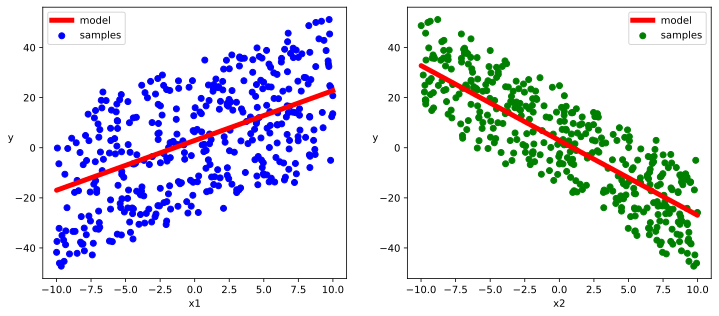

In [26]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()